In [1]:
import pandas as pd
import json
import os
import seaborn as sns
sns.set(style='ticks', context='paper')
import numpy as np
from util import plot_scatter

In [2]:
P99_PERCENTILE_LIST = np.arange(1, 101, 1)
MTU=1000
BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=5BDP', 3:'5BDP<size'}

n_size_bucket_list_output=len(bin_size_list)+1
n_percentiles=len(P99_PERCENTILE_LIST)

In [13]:
N_FLOW_THRESHOLD=1
NR_PATHS_SAMPLED=500
NR_INTEPOLATE=100
N_FLOWS=NR_PATHS_SAMPLED*NR_INTEPOLATE*40
data_dir='_hpcc'
shard_seed=4

mlsys_dir_list=["mlsys"]
legend_list=['ns3-config','pmn-m',"mlsys"]
res=[]
for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
    save_file=f'./config_gen_{mlsys_dir}_p{NR_PATHS_SAMPLED}_l{NR_INTEPOLATE}_t{N_FLOW_THRESHOLD}{data_dir}.npz'
    if not os.path.exists(save_file):
        res_final=[]
        n_flows_in_f_list_final=[]
        for worst_low_id in range(25):
            mix_dir = f'../data{data_dir}/{worst_low_id}'
            if not os.path.exists(f'{mix_dir}/{legend_list[0]}/elapsed_{shard_seed}.txt'):
                print(f'{worst_low_id}: No GT!')
                res_final.append(np.zeros((n_size_bucket_list_output+1,2)))
                n_flows_in_f_list_final.append(np.zeros(NR_PATHS_SAMPLED))
                continue
            
            res_tmp=[]
            df_pmn_m = pd.read_csv(f'{mix_dir}/{legend_list[1]}/records.csv')
            
            n_freq_list=[]
            n_flows_in_f_list=[]
            n_flow_list=[]
            sizes_pmn=df_pmn_m['size']
            
            path_idx=0
            while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
                with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
                    lines = file.readlines()
                    data=lines[0].strip().split(",")
                    n_freq=int(data[-1])
                    n_freq_list.append(n_freq)
                    for _ in range(n_freq):
                        n_flows_in_f_list.append(int(data[-3]))
                    
                    flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
                    size_list=[sizes_pmn[flowid] for flowid in flowid_list]
                    
                    n_links=len(data[0].split("|"))-1
                    tmp=np.digitize(size_list, bin_size_list)
                    # Count occurrences of each bin index
                    bin_counts = np.zeros(n_size_bucket_list_output)
                    for bin_idx in tmp:
                        bin_counts[bin_idx]+=1
                    n_flow_list.append(bin_counts)
                path_idx+=1
            assert sum(n_freq_list)==NR_PATHS_SAMPLED
            n_flow_list=np.array(n_flow_list)
            n_flow_list_sum=n_flow_list.sum(axis=0)
            
            n_flows_in_f_list_final.append(n_flows_in_f_list)
            
            df_ns3 = pd.read_csv(f'{mix_dir}/{legend_list[0]}/records_{shard_seed}.csv')
            
            df_mlsys = [[] for _ in range(n_size_bucket_list_output)]
            
            sizes_ns3=np.array(df_ns3['size'])
            bin_ns3=np.digitize(sizes_ns3, bin_size_list)
            bin_counts = np.bincount(bin_ns3)
            total_count = np.sum(bin_counts)
            bucket_ratios = bin_counts / total_count
            
            with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
                lines = file.readlines()
            lines = lines[1:]
            for line_idx,line in enumerate(lines):
                data=line.strip().split(",")
                data = [float(value) for value in data]
                assert len(data) == NR_INTEPOLATE
                n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
                
                if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD:
                    for _ in range(n_freq):
                        df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
                
            df_mlsys_shape=[len(df_mlsys[i]) for i in range(len(df_mlsys))]
            print(f"{worst_low_id}: {df_mlsys_shape}, {np.max(n_freq_list)}")
            print("bucket_ratios: ",bucket_ratios)
            bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
            print("bucket_ratios_sampled: ",bucket_ratios_sampled)
            
            sldn_mlsys_p99=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
            
            print("df_mlsys_p99: ",sldn_mlsys_p99)
            df_mlsys_total=[]
            for i in range(len(df_mlsys)):
                n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
                df_mlsys_total.extend(np.random.choice(df_mlsys[i],n_tmp,replace=True))
            sldn_mlsys_p99=np.percentile(df_mlsys_total,99)

            sldn_ns3=df_ns3['slowdown']
            sldn_ns3_p99=np.percentile(sldn_ns3,99)
            
            print("sldn_ns3: ",sldn_ns3_p99," sldn_mlsys: ", sldn_mlsys_p99)

            res_tmp.append([sldn_ns3_p99,sldn_mlsys_p99])
            
            for i in range(len(bin_size_list)+1):
                tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
                tmp_sldn_mlsys=df_mlsys[i]
                
                sldn_ns3_p99=np.percentile(tmp_sldn_ns3,99)
                df_mlsys_p99=np.percentile(tmp_sldn_mlsys,99)
                res_tmp.append([sldn_ns3_p99,df_mlsys_p99])
            res_final.append(res_tmp)
        res_final = np.array(res_final)
        n_flows_in_f_list_final = np.array(n_flows_in_f_list_final)
        print("res:", res_final.shape,n_flows_in_f_list_final.shape)
        np.savez(save_file,res_final=res_final,n_flows_in_f_list_final=n_flows_in_f_list_final)
    else:
        data=np.load(save_file)
        res_final=data['res_final']
        n_flows_in_f_list_final=data['n_flows_in_f_list_final']
    if mlsys_dir_idx==0:
        res.append(res_final[:,:,0].transpose())
        res.append(res_final[:,:,1].transpose())
    else:
        res.append(res_final[:,:,-1].transpose())
res=np.array(res)

mix_file = f'../spec/all_counterfactual{data_dir}.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 
mask=[]
cc_dict={
    "dctcp":"dctcp",
    "timely": "timely_vwin",
    "dcqcn": "dcqcn_paper_vwin",
    "hp": "hp",
}
for mix in mixes:
    config_id=mix['id']
    cc=mix['cc']
    if not os.path.exists(f"../data{data_dir}/{config_id}/ns3-config/{shard_seed}/flows.txt") and not os.path.exists(f"../data{data_dir}/{config_id}/ns3-config/{shard_seed}/fct_topology_flows_{cc_dict[cc]}.txt"):
        mask.append(True)
    else:
        mask.append(False)
mask=np.array(mask)
print(res.shape)
n_flows_median_list=np.median(n_flows_in_f_list_final,axis=1)
print("n_flows_median_list: ",n_flows_median_list.shape)

0: [49900, 49900, 48300, 49500], 2
bucket_ratios:  [0.35765992 0.44388191 0.08905345 0.10940472]
bucket_ratios_sampled:  [0.35840766 0.44287974 0.08799815 0.11071444]
df_mlsys_p99:  [2.77719742 3.30928656 4.88881116 5.89487171]
sldn_ns3:  4.1491740757401745  sldn_mlsys:  4.041964
1: [49900, 49900, 48300, 49500], 2
bucket_ratios:  [0.35765992 0.44388191 0.08905345 0.10940472]
bucket_ratios_sampled:  [0.35840766 0.44287974 0.08799815 0.11071444]
df_mlsys_p99:  [2.63982282 3.27001867 4.85329509 5.88157062]
sldn_ns3:  3.942805430920136  sldn_mlsys:  4.028141
2: [49900, 49900, 48300, 49500], 2
bucket_ratios:  [0.35765992 0.44388191 0.08905345 0.10940472]
bucket_ratios_sampled:  [0.35840766 0.44287974 0.08799815 0.11071444]
df_mlsys_p99:  [2.584666   3.26130702 4.84045755 5.86506039]
sldn_ns3:  3.893850192620357  sldn_mlsys:  4.020774000000002
3: [49900, 49900, 48300, 49500], 2
bucket_ratios:  [0.35765992 0.44388191 0.08905345 0.10940472]
bucket_ratios_sampled:  [0.35840766 0.44287974 0.0879

In [8]:
file2matrix = {
        '../../workload/spatials/cluster_a_2_16.json': 'Traffic Matrix A',
        '../../workload/spatials/cluster_b_2_16.json': 'Traffic Matrix B',
        '../../workload/spatials/cluster_c_2_16.json': 'Traffic Matrix C',
    }
file2oversub = {
        'spec/cluster_1_to_1.json': '1-to-1',
        'spec/cluster_2_to_1.json': '2-to-1',
        'spec/cluster_4_to_1.json': '4-to-1',
    }
file2dist = {
    '../../workload/distributions/facebook/webserver-all.txt': 'WebServer',
    '../../workload/distributions/facebook/hadoop-all.txt': 'Hadoop',
    '../../workload/distributions/facebook/cachefollower-all.txt': 'CacheFollower',
}
load_dict={
    0: "load: 0.25-0.35",
    1: "load: 0.35-0.45",
    2: "load: 0.45-0.55",
    3: "load: 0.55-0.65",
    4: "load: 0.65-0.75",
}
window_dict={
    0: "window: 05-14KB",
    1: "window: 14-23KB",
    2: "window: 23-30KB",
}
bfsz_dict={
    0: "buffer: 200-300KB",
    1: "buffer: 300-400KB",
    2: "buffer: 400-500KB",
}
dctcp_k_dict={
    0: "k: 05-9KB",
    1: "k: 09-13KB",
    2: "k: 13-17KB",
    3: "k: 17-20KB",
}
timely_tmin_dict={
    0: "tmin: 40-45us",
    1: "tmin: 45-50us",
    2: "tmin: 50-55us",
    3: "tmin: 55-60us",
}
timely_tmax_dict={
    0: "tmax: 100-113us",
    1: "tmax: 113-126us",
    2: "tmax: 126-139us",
    3: "tmax: 139-150us",
}
hp_ai_dict={
    0: "ai: 0500-625mbps",
    1: "ai: 0625-750mbps",
    2: "ai: 0750-875mbps",
    3: "ai: 875-1000mbps",
}
hp_ita_dict={
    0: "ita: 0.7-0.77",
    1: "ita: 0.77-0.84",
    2: "ita: 0.84-0.91",
    3: "ita: 0.91-0.95",
}
dcqcn_kmin_dict={
    0: "kmin: 20-28KB",
    1: "kmin: 28-36KB",
    2: "kmin: 36-44KB",
    3: "kmin: 44-50KB",
}
dcqcn_kmax_dict={
    0: "kmax: 50-63KB",
    1: "kmax: 63-76KB",
    2: "kmax: 76-89KB",
    3: "kmax: 89-100KB",
}
cc_legend_dict={
    "dctcp": "DCTCP",
    "timely": "TIMELY",
    "dcqcn": "DCQCN",
    "hp": "HPCC",
}

None
(2, 6, 2)
(6, 2)
(6, 2)
None
(2, 6, 2)
(6, 2)
(6, 2)
['load=34%\nwind=24KB\n', 'load=38%\nwind=6KB\n', 'load=62%\nwind=19KB\n', 'load=73%\nwind=28KB\n', 'load=30%\nwind=21KB\n', 'load=51%\nwind=23KB\n']
(2, 6, 2)
(6, 2)
(6, 2)
None
(2, 6, 2)
(6, 2)
(6, 2)


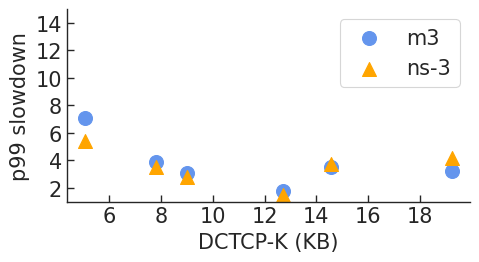

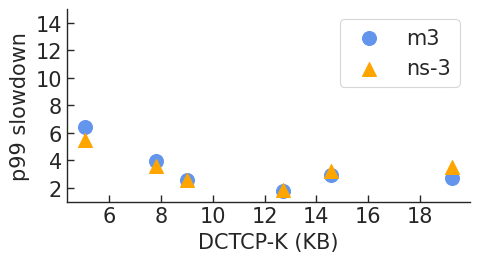

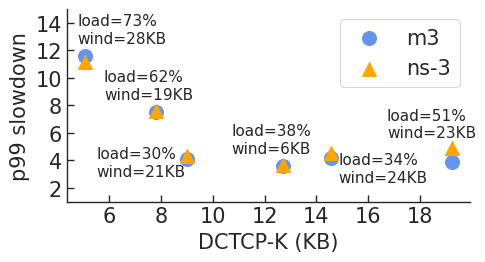

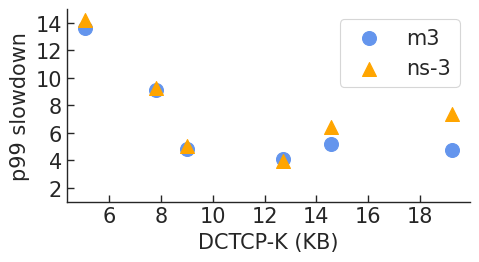

In [5]:

text_offset=[(0.3, -3),(-2, -0.3),(-2, -0.3),(-0.3, -0.3),(-3.5, -2.5),(-2.5, 0.5)]
for i in range(1,5):
    res_tmp=res[:,i]
    plot_res=[]
    text_info=[]
    for mix_id in range(len(mixes)):
        if mask[mix_id]==False:
            continue
        mix=mixes[mix_id]
        cc=mix['cc']
        spatial=file2matrix[mix["spatial"]]
        size_dist=file2dist[mix["size_dist"]]
        oversub=file2oversub[mix["cluster"]]
        
        spatial!="Traffic Matrix A" or mix["enable_pfc"]!=0.0: continue
        dctcp_k=mix["param_1"]
        tmp=[[dctcp_k,res_tmp[1,mix_id]],[dctcp_k,res_tmp[0,mix_id]]]
        plot_res.append(tmp)
        
        load=mix["max_load"]
        load=f"{int(load*100)}%"
        window=mix["window"]
        window=f"{int(window/1000)}KB"
        text_tmp=f"load={load}\nwind={window}\n"
        text_info.append(text_tmp)
    if i!=3:
        text_info=None
    print(text_info)
    plot_res=np.array(plot_res)
    plot_res=plot_res.transpose(1, 0, 2)
    print(plot_res.shape)
    plot_scatter(plot_res,f"figs/counterfactual_size_{i-1}_dctcpk.pdf",['m3','ns-3'],'DCTCP-K (KB)',y_label='p99 slowdown',legend_font=15,loc=1,rotate_xaxis=False,frameon=True,ncol=1,enable_legend=True,text_info=text_info,text_offset=text_offset,ylim=15,ylim_bottom=1,marker_size=100)

None
(2, 25, 2)
(25, 2)
(25, 2)
None
(2, 25, 2)
(25, 2)
(25, 2)
None
(2, 25, 2)
(25, 2)
(25, 2)
None
(2, 25, 2)
(25, 2)
(25, 2)


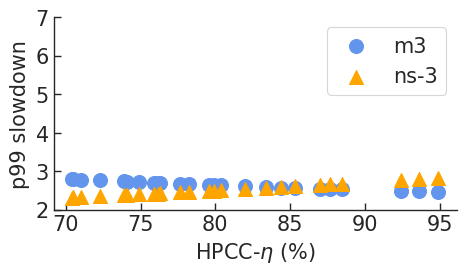

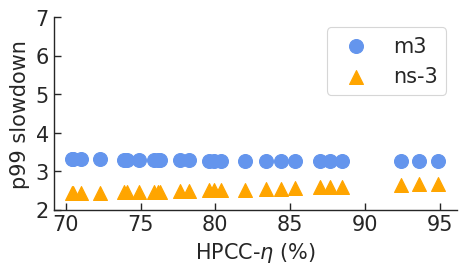

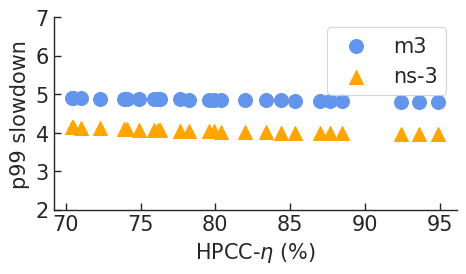

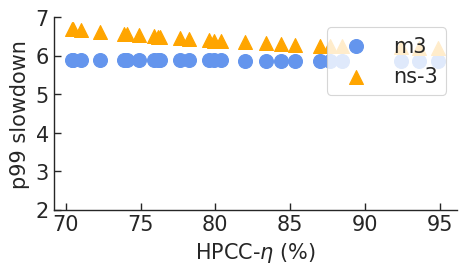

In [15]:

text_offset=[(-4.3, -2),(-4.3, -1),(-3, -0.3),(-0.3, -4),(-0.5, 1)]
for i in range(1,5):
    res_tmp=res[:,i]
    plot_res=[]
    text_info=[]
    for mix_id in range(len(mixes)):
        if mask[mix_id]==False:
            continue
        mix=mixes[mix_id]
        cc=mix['cc']
        spatial=file2matrix[mix["spatial"]]
        size_dist=file2dist[mix["size_dist"]]
        oversub=file2oversub[mix["cluster"]]
        
        if mix["cc"]!="hp" or size_dist!="WebServer" or spatial!="Traffic Matrix B" or mix["enable_pfc"]!=1.0: continue
        hp_ita=mix["param_1"]
        tmp=[[hp_ita,res_tmp[1,mix_id]],[hp_ita,res_tmp[0,mix_id]]]
        plot_res.append(tmp)
        
        load=mix["max_load"]
        load=f"{int(load*100)}%"
        window=mix["window"]
        window=f"{int(window/1000)}KB"
        text_tmp=f"load={load}\nwind={window}\n"
        text_info.append(text_tmp)
    # if i!=4:
    text_info=None
    print(text_info)
    plot_res=np.array(plot_res)
    plot_res=plot_res.transpose(1, 0, 2)
    print(plot_res.shape)
    plot_scatter(plot_res,f"figs/counterfactual_size_{i-1}_hpeta.pdf",['m3','ns-3'],'HPCC-$\eta$ (%)',y_label='p99 slowdown',legend_font=15,loc=1,rotate_xaxis=False,frameon=True,ncol=1,enable_legend=True,text_info=text_info,text_offset=text_offset,ylim_bottom=2,ylim=7,marker_size=100)